This tutorial will walk you through the basic concept to understand representational similarity analysis (RSA) and how to apply it using the PcmPy toolbox. To find out how to use the rsatoolbox instead you can check this tutorial.

In [8]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import PcmPy as pcm
import pandas as pd
import nitools as nt
import pickle

plt.style.use('default')


In [9]:
f = open('data_demo_smp.p', 'rb')
Y, cond_vec, part_vec, cond_names = pickle.load(f)
N = Y.shape[1]

A central concept to keep in mind to understand RSA is the **second moment matrix** $\mathbf{G}$:

$$ G = \frac{{YY^T}}{P} $$

Where $Y$ is a matrix with experimental observations (e.g., trials, conditions) in the rows and channels (e.g., electrodes, voxels) in the columns and $P$ is the number of channels. In our example case, each row in Y contains the beta coefficients estimated in S1 for each condition. Note that the second moment matrix is different from the variance-covariance matrix:

$$ \mathsf{\Sigma} = \frac{(Y - \bar{Y})^T (Y - \bar{Y})}{N - 1} $$

Here, we subtract the column-wise mean $\bar{Y}$ from $Y$. Instead, the second moment matrix maintains information about the mean activation observed in each condition.

Let's now compute the second moment matrix for the first run in our example data and see how it looks like:

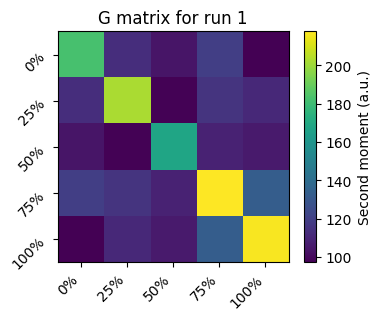

In [33]:
G = Y[:5] @ Y[:5].T / N

plt.figure(figsize=(4,3))
plt.imshow(G)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45, ha='right')
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45, ha='right')
plt.title('G matrix for run 1')
plt.colorbar(label='Second moment (a.u.)')
plt.show()

From the second moment matrix it is possible to calculate the squared euclidean distances between conditions. The squared euclidean distance between two vectors $ \mathsf{y}_{i} $ and $ \mathsf{y}_{j} $ is:

$$ \mathsf{D}_{i,j}^2 = (y_{i} - y_{j})(y_{i} - y_{j})^T $$

Expanding the terms inside the parentheses:

$$ \mathsf{D}_{i,j}^2 = y_{i}y_{j}^T - 2y_{i}y_{j}^T + y_{i}y_{j}^T $$

Looking back at the definition of second moment matrix:

$$ {G}_{i,i} = \frac{y_{i}y_{i}^T}{P} $$

Therefore, we can rewrite the squared Euclidean distance formula for the first block:

$$ {D}_{i,j}^2 = \frac{G_{i,i} - 2G_{i,j} + G_{j,j}}{P} $$

In PcmPy, we can compute the ${D}^2$ from $G$ using the `G_to_dist` function. This is how it looks like:

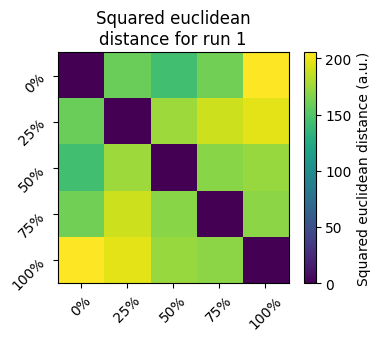

In [32]:
D_eucl = pcm.G_to_dist(G)

plt.figure(figsize=(4,3))
plt.imshow(D_eucl)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Squared euclidean\ndistance for run 1')
plt.colorbar(label='Squared euclidean distance (a.u.)')

The problem with this distance metric is that it will be always (and trivially) larger than zero, even when there is no true distance between conditions. This is because data are collected in the presence of noise. Noise inflates distances: two conditions will be always show some distance relative to each other because noise pulls them apart. Using the above definition of second moment matrix $G$, in the first block the second moment matrix $\hat{G_{1}}$ is estimated as:

$$ \hat{G_{1}} = \frac{{Y_{1}Y_{1}^T}}{N} $$

But $Y_{1}$ is affected noise $ \epsilon_{1} $:

$$ \hat{G_{1}} = (Y_{1} + \epsilon_{1})(Y_{1} + \epsilon_{1})^T $$

Expanding:

$$ \hat{G_{1}} = Y_{1}Y_{1}^T + Y_{1}\epsilon^T + \epsilon_{1} Y_{1}^T + \epsilon_{1} \epsilon_{1}^T $$

$ Y_{1}\epsilon^T=0 $  because noise is assumed to be orthogonal to the data. Therefore:

$$ \hat{G_{1}} = Y_{1}Y_{1}^T + \epsilon_{1} \epsilon_{1}^T $$

$\epsilon_{1} \epsilon_{1}^T$ corresponds to the covariance of the noise $\Sigma$. Thus, the expected value of $\hat{G_{1}}$ is:

$$\mathbb{E}[\hat{G_{1}}] = G_{1} + \Sigma $$

As a consequence, the expected estimate of distance between two conditions y_{1,i} and y_{1,j} in the first block becomes:

$$\mathbb{E}[\hat{D_{1,i,j}^2}] = y_{i}y_{i}^T + \epsilon_{1,i}\epsilon_{1,i}^T - 2(y_{1,i}y_{1,j}^T + \epsilon_{i,1}\epsilon_{j,1}^T) + y_{j}y_{j}^T + \epsilon_{j,1}\epsilon_{j,1}^T $$

That is, the estimate of the distance $\hat{D_{1,i,j}^2}$ is inflated by $ \epsilon_{1,i}\epsilon_{1,i}^T -2\epsilon_{i,1}\epsilon_{j,1}^T +  \epsilon_{j,1}\epsilon_{j,1}^T$

How do we obtain an unbiased $\hat{G}$ that gets rid of $\Sigma$? In RSA, this is achieved by computing the cross-validated second moment matrix $G_{cv}$:

$$ Gc = \frac{1}{N} \sum_{i=1}^{N} Y_i \bar{Y_{\neg i}}^T $$

Where $N$ is the number of blocks Y_i is the data from one block and $\bar{Y_{\neg i}}$ is the average of all blocks except $i$:

$$ \bar{Y}_{\neg i} = \frac{1}{N-1} \sum_{j \neq i} Y_j $$

The cross-validated second moment matrix between two blocks $i$ and $j$ is:

$$ \hat{Gc_{i,j}} = \frac{{Y_{i}Y_{j}^T}}{P} $$

$Y_i$ and $Y_j$ will be affected by noise $\epsilon_i$ and $\epsilon_j$:

$$ \hat{Gc_{i,j}} = (Y_{i} + \epsilon_{i})(Y_{i} + \epsilon_{j})^T $$

Expanding:

$$ \hat{Gc_{i,j}} = Y_{i}Y_{j}^T + Y_{i}\epsilon_{j}^T + \epsilon_{i}Y_{j}^T + \epsilon_{i} \epsilon_{j}^T $$

In this case, not only Y_{i}\epsilon_{j}^T=0 and \epsilon_{i}Y_{j}^T=0, but also \epsilon_{i} epsilon_{j}^T=0 because the noise is assumed to be orthogonal between different blocks. This means that, with cross-validation, we achieved an unbiased estimate of the second moment matrix.

The cross-validated G matrix can be computed in PcmPy using the `est_G_crossval` function. `cond_vec` is  a vector of condition labels and `part_vec` is a vector of partition labels (i.e., the block number):


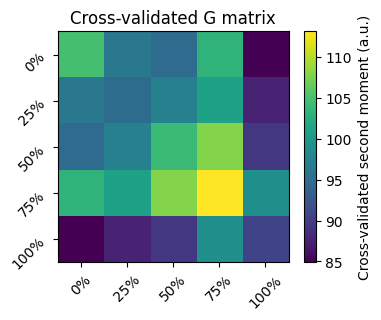

In [31]:
G_cv, _ = pcm.est_G_crossval(Y, cond_vec, part_vec)

plt.figure(figsize=(4, 3))
plt.imshow(G_cv)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated G matrix')
plt.colorbar(label='Cross-validated second moment (a.u.)')

From `G_cv` we can now compute the cross-validated squared euclidean distance with `G_to_dist`:

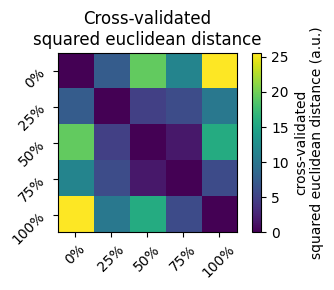

In [28]:
D_eucl_cv = pcm.G_to_dist(G_cv)

plt.figure(figsize=(4,3))
plt.imshow(D_eucl_cv)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated\nsquared euclidean distance')
plt.colorbar(label='cross-validated\nsquared euclidean distance (a.u.)')
plt.tight_layout()

There is another problem that we need to address to accurately estimate distances. Different channels often have different variance, or are correlated with each other.

(-30.0, 80.0)

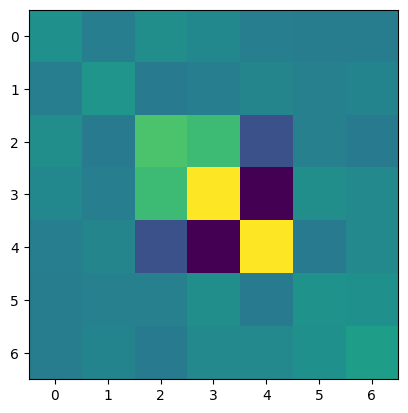

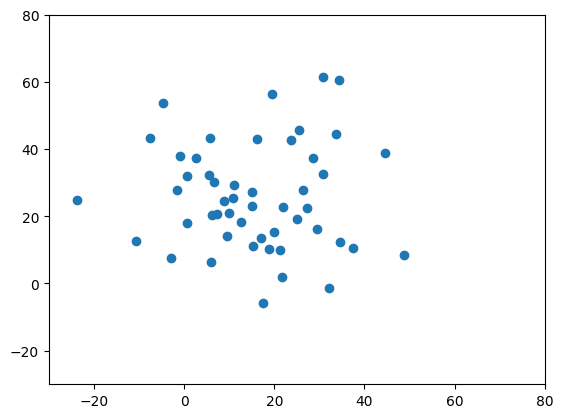

In [51]:
# plt.imshow(Y[:, 38:45].T @ Y[:, 38:45])

Y_prewhitened

plt.figure()
plt.scatter(Y[:,40], Y[:,41])
plt.ylim((-30, 80))
plt.xlim((-30, 80))